In [ ]:
# Author: Elahe Golrokh
# Repo: https://github.com/ElahehGolrokh/data-science-salary-range

***Important Note:*** The following analyses are intended solely to demonstrate statistical methods and reasoning. The dataset is noisy, not collected through a random sampling process, and may not be representative of the population. Therefore, the results should not be interpreted as valid inferences about real-world salaries.

In [1]:
import ast
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns

from collections import Counter
from scipy import stats
from scipy.stats import ttest_1samp


In [ ]:
from google.colab import files
files.upload()

In [2]:
df = pd.read_csv('/content/df_feature_engineered.csv')
df.head()

,job_title,seniority_level,status,company,location,headquarter,industry,ownership,company_size,revenue,skills,min_salary,max_salary,mean_salary
0,data scientist,senior,hybrid,company_003,United States,United States,Retail,Public,NaN,3.524400e+11,"['spark', 'r', 'python', 'scala', 'machine lea...",100472.0,200938.0,150705.0
1,data scientist,lead,hybrid,company_005,United States,United States,Manufacturing,Public,155030.0,5.110000e+10,"['spark', 'r', 'python', 'sql', 'machine learn...",118733.0,118733.0,118733.0
2,data scientist,senior,on-site,company_007,multi-location,United States,Technology,Public,25930.0,3.380000e+10,"['aws', 'git', 'python', 'docker', 'sql', 'mac...",94987.0,159559.0,127273.0
3,data scientist,senior,hybrid,company_008,multi-location,United States,Technology,Public,34690.0,8.171000e+10,"['sql', 'r', 'python']",112797.0,194402.0,153599.5
4,data scientist,NaN,on-site,company_009,United States,United States,Finance,Private,1800.0,NaN,[],114172.0,228337.0,171254.5


# **General Stats**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 938 entries, 0 to 937
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   job_title        935 non-null    object 
 1   seniority_level  880 non-null    object 
 2   status           685 non-null    object 
 3   company          938 non-null    object 
 4   location         938 non-null    object 
 5   headquarter      938 non-null    object 
 6   industry         938 non-null    object 
 7   ownership        906 non-null    object 
 8   company_size     900 non-null    float64
 9   revenue          421 non-null    float64
 10  skills           938 non-null    object 
 11  min_salary       938 non-null    float64
 12  max_salary       938 non-null    float64
 13  mean_salary      938 non-null    float64
dtypes: float64(5), object(9)
memory usage: 102.7+ KB


In [ ]:
df.isnull().sum()

,0
job_title,3
seniority_level,58
status,253
company,0
location,0
headquarter,0
industry,0
ownership,32
company_size,38
revenue,517


In [ ]:
df.describe(include='all')

,job_title,seniority_level,status,company,location,headquarter,industry,ownership,company_size,revenue,skills,min_salary,max_salary,mean_salary
count,935,880,685,938,938,938,938,906,900.000000,4.210000e+02,938,9.380000e+02,9.380000e+02,9.380000e+02
unique,4,4,3,417,7,5,8,2,NaN,NaN,399,NaN,NaN,NaN
top,data scientist,senior,on-site,company_134,United States,United States,Technology,Public,NaN,NaN,[],NaN,NaN,NaN
freq,853,627,363,30,566,768,576,579,NaN,NaN,196,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97825.651111,1.645563e+11,NaN,1.144924e+05,1.489748e+05,1.317336e+05
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,185069.173560,2.159307e+11,NaN,1.265327e+05,1.343738e+05,1.290955e+05
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,9.133300e+08,NaN,4.055000e+03,7.678000e+03,7.055000e+03
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1795.000000,2.653000e+10,NaN,6.841600e+04,8.237150e+04,7.646000e+04
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20335.000000,8.220000e+10,NaN,1.104005e+05,1.512265e+05,1.347225e+05
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,94570.000000,2.303700e+11,NaN,1.461390e+05,2.009360e+05,1.697328e+05


# **Utils**

## Helper Functions

In [3]:
def remove_outliers_iqr(data, column):
    """
    Removes outliers from a pandas DataFrame column using the IQR method.

    Parameters:
    -----------
    data : pd.DataFrame
        The input DataFrame
    column : str
        The column name on which to apply the IQR filter

    Returns:
    --------
    pd.Series : Cleaned data (outliers removed)
    """
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    cleaned = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return cleaned

## Plot's Functions

In [4]:
def plot_numerical_histogram(df: pd.DataFrame,
                             col: str,
                             x_label: str,
                             title: str,
                             ):
  plt.rcParams["font.size"] = 14
  fig, (ax_hist, ax_box) = plt.subplots(
      2, sharex=True, gridspec_kw={"height_ratios": (0.85, 0.15)}, figsize=(16, 8)
  )
  # boxplot (seaborn)
  sns.boxplot(x=df[col], color="gray", ax=ax_box)
  ax_box.set(xlabel="")
  # histogram (matplotlib)
  ax_hist.hist(df[col], bins=40, density=True, color="gray")
  # kde plot (pandas series)
  min_, max_ = plt.xlim()
  plt.xlim(min_, max_)

  ax_hist.set_title(
      title,
      weight="bold",
      color="gray",
      fontsize=18,
      loc="left",
  )

  ax_hist.set_xlabel(x_label, loc="left", weight="bold", fontsize=14, color="gray")

  ax_hist.set_ylabel(
      "Density",
      loc="bottom",
      weight="bold",
      fontsize=14,
      color="gray",
  )

  ax_box.spines[["right", "top", "left", "bottom"]].set_visible(False)

  ax_hist.spines[["right", "top"]].set_visible(False)
  ax_hist.ticklabel_format(axis="x", style="plain")
  ax_hist.tick_params(axis="x", colors="gray", labelsize="large")
  ax_hist.tick_params(axis="y", colors="gray", labelsize="large")

  df[col].plot.kde(color="lightcoral", linewidth=3, ax=ax_hist)

  plt.tight_layout()
  plt.show()

# **Checking Assumptions**

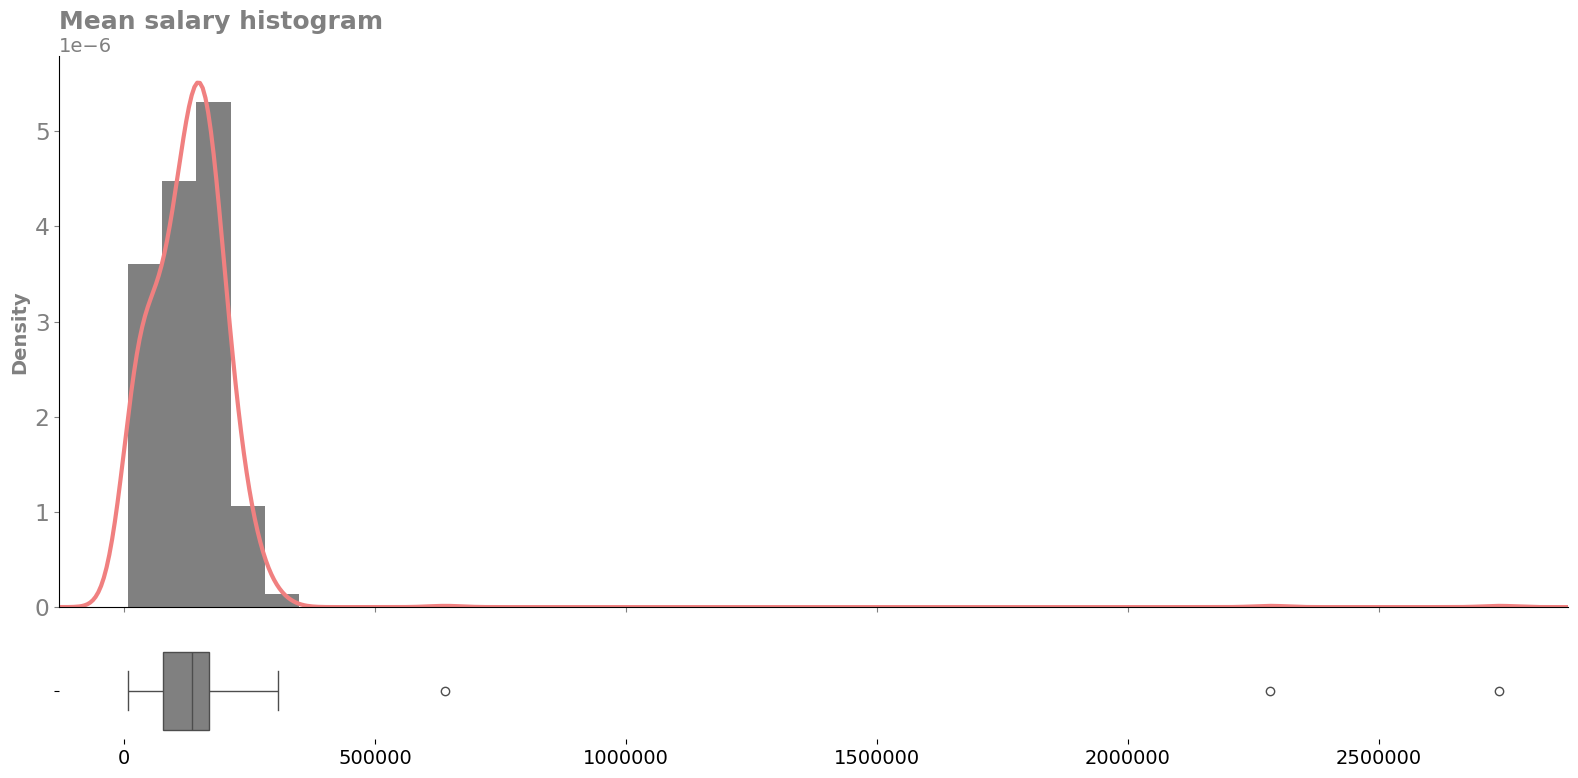

In [6]:
plot_numerical_histogram(df=df,
                         col="mean_salary",
                         x_label="mean_salary",
                         title="Mean salary histogram",
                         )

From the histogram + boxplot, we can see:
* Most mean_salary values fall below ~$300k.

* A few extreme outliers exist (in the $600k–$2.5M range).

Parametric tests work well if distribution is roughly symmetric and outliers are handled. With 𝑛 = 938, CLT makes it very robust, even if slightly skewed. So we can go ahead with parametric test. First we apply IQR filtering (drop values > Q3 + 1.5*IQR, which should cut those million-dollar salaries) & then run the t-test on cleaned data.

# **Data Cleaning**

In [5]:
df_clean = remove_outliers_iqr(df, "mean_salary")

print("Original size:", df["mean_salary"].notna().sum())
print("After IQR cleaning:", df_clean.shape[0])
print("Cleaned mean salary:", df_clean['mean_salary'].mean())

Original size: 938
After IQR cleaning: 935
Cleaned mean salary: 126099.98770053477


In [6]:
# Approximate exchange rate (Euros to US Dollars)
exchange_rate_eur_usd = 1.08

# Convert mean_salary from Euros to US Dollars
df_clean['mean_salary_usd'] = df_clean['mean_salary'] * exchange_rate_eur_usd

# Display the first few rows with the new column
display(df_clean[['mean_salary', 'mean_salary_usd']].head())

/tmp/ipython-input-2569314541.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['mean_salary_usd'] = df_clean['mean_salary'] * exchange_rate_eur_usd


,mean_salary,mean_salary_usd
0,150705.0,162761.40
1,118733.0,128231.64
2,127273.0,137454.84
3,153599.5,165887.46
4,171254.5,184954.86


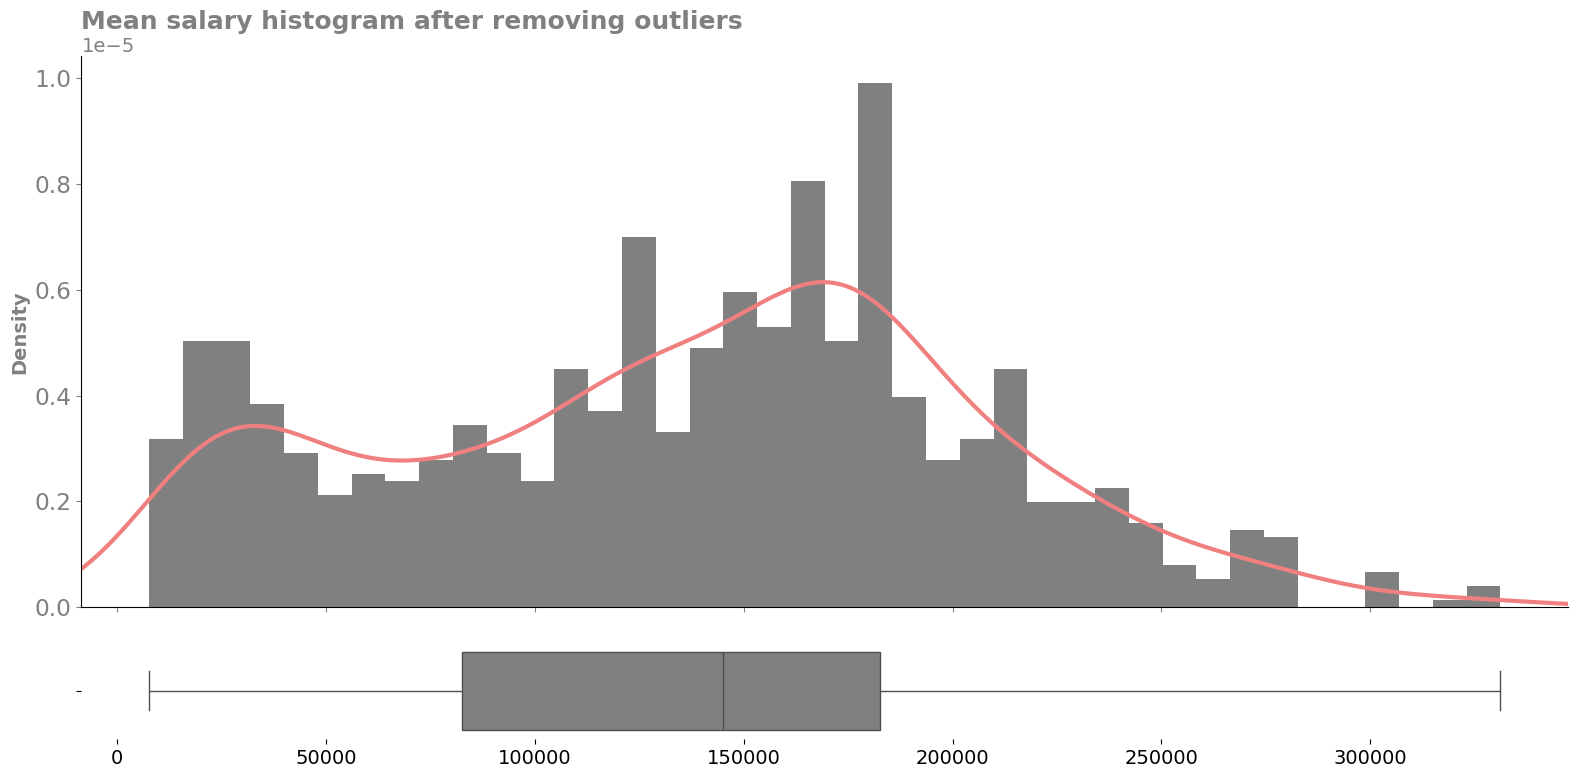

In [8]:
plot_numerical_histogram(df=df_clean,
                         col="mean_salary_usd",
                         x_label="mean_salary_usd",
                         title="Mean salary histogram after removing outliers",
                         )

# **Inferential Statistics**
In this section, we present key questions regarding data scientist salaries and address them using **hypothesis testing** and **confidence interval analysis**.

## **Question #1: Mean Data Scientist salaries in the US**

**Based on salary aggregators like Indeed and Glassdoor, the mean salary for a Data Scientist in the U.S. is around $128,000 as of May 2024. Test whether your sample provides evidence that the "real" mean salary is different than this claimed salary.**

---

In [9]:
df_US = df_clean[df_clean['location'] == 'United States']
df_US.shape

(566, 15)

### **Hypothesis Test**

**Null Hypothesis (H₀):** The true mean salary of data scientists in the population = $128,000.

<p align="center">𝐻0 : 𝜇 = 128,000</p>

We want to test for any difference (two-tailed):

<p align="center">𝐻1 : 𝜇 ≠ 128,000</p>

We use a t-test (even with such large  𝑛 ) because the one-sample t-test is the standard choice when we don’t know the population standard deviation (
𝜎).

Instead, we estimate variability using the sample standard deviation (s). The t-distribution accounts for the extra uncertainty introduced by using 𝑠
instead of 𝜎.

With a very large sample size (𝑛 > 30, and especially with our  𝑛 ≈ 566), the t-distribution approaches the normal distribution.

In fact, the difference between the t-test and z-test results becomes negligible. But we still stick with the t-test because in our dataset, we don’t know 𝜎 , only the sample estimate.

Using the t-test is statistically “safer,” and with large 𝑛 , it essentially gives the same result as the z-test anyway.


In [11]:
# --- Two-tailed one-sample t-test against claimed mean (e.g., 128000) ---
claimed_mean = 128000
t_stat, p_val = ttest_1samp(df_US['mean_salary_usd'], claimed_mean)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_val}")
print(f"Mean Salary in USD: {df_US['mean_salary_usd'].mean()}")

# Interpret the results
alpha = 0.05
if p_val < alpha:
    print("Reject the null hypothesis: The true mean salary is significantly different from $128,000.")
else:
    print("Fail to reject the null hypothesis: There is not enough evidence to conclude that the true mean salary is different from $128,000.")

T-statistic: 17.28547381728916
P-value: 4.7154961676004874e-54
Mean Salary in USD: 164677.4974558304
Reject the null hypothesis: The true mean salary is significantly different from $128,000.


### **Confidence Interval**

In [12]:
# --- 95% confidence interval for the sample mean ---
mean = df_US['mean_salary_usd'].mean()
std = df_US['mean_salary_usd'].std()
n = len(df_US['mean_salary_usd'])
print(f"Mean: {mean}\nStd: {std}\nN: {n}")

ci_low = mean - stats.t.ppf(0.975, n-1) * std/np.sqrt(n)
ci_high = mean + stats.t.ppf(0.975, n-1) * std/np.sqrt(n)
print(f"95% confidence interval: ({ci_low}, {ci_high})")

Mean: 164677.4974558304
Std: 50480.84577354737
N: 566
95% confidence interval: (160509.78427590424, 168845.21063575655)


## **Question #2: Salary Differences by Seniority Level**

**Do senior data scientists earn significantly higher mean salaries than junior/mid-level data scientists in the US?**

---



In [13]:
df_US = df_clean[df_clean['location'] == 'United States']
df_US.shape

(566, 15)

In [14]:
df_US['seniority_level'].value_counts()

,count
seniority_level,
senior,383
lead,80
midlevel,59
junior,11


### **Hypothesis Test**

**Null Hypothesis (H₀):** There is no difference in the mean salary between senior-level and junior/mid-level data scientists.

**Alternative Hypothesis (H₁):** Senior-level data scientists have a higher mean salary than junior/mid-level data scientists.

We could use a t-test (two-sample, unequal variances) if comparing two groups.




In [15]:
# Split the data
senior_salaries = df_US[df_US['seniority_level'] == 'senior']['mean_salary_usd']
junior_mid_salaries = df_US[df_US['seniority_level'].isin(['junior', 'midlevel'])]['mean_salary_usd']

# Calculate descriptive statistics
print("Senior mean salary:", senior_salaries.mean())
print("Junior/Mid mean salary:", junior_mid_salaries.mean())

# Perform Welch's t-test (does not assume equal variance)
t_stat, p_value = stats.ttest_ind(senior_salaries, junior_mid_salaries, equal_var=False)
print("Welch's t-test:")
print("t-statistic:", t_stat)
print("p-value:", p_value)

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: Senior-level data scientists have a higher mean salary than junior/mid-level data scientists.")
else:
    print("Fail to reject the null hypothesis: There is not enough evidence to conclude that There is no difference in the mean salary between senior-level and junior/mid-level data scientists.")

Senior mean salary: 162600.39399477807
Junior/Mid mean salary: 149503.11942857146
Welch's t-test:
t-statistic: 2.181071586325205
p-value: 0.03154925395419288
Reject the null hypothesis: Senior-level data scientists have a higher mean salary than junior/mid-level data scientists.


### **Confidence Interval**

In [16]:
diff_mean = senior_salaries.mean() - junior_mid_salaries.mean()

# Standard errors
se_senior = senior_salaries.var(ddof=1) / len(senior_salaries)
se_junior = junior_mid_salaries.var(ddof=1) / len(junior_mid_salaries)
se_diff = np.sqrt(se_senior + se_junior)

# Welch-Satterthwaite degrees of freedom
df_welch = (se_senior + se_junior)**2 / ((se_senior**2) / (len(senior_salaries)-1) + (se_junior**2) / (len(junior_mid_salaries)-1))

# 95% confidence interval (two-tailed)
alpha = 0.05
t_crit = stats.t.ppf(1 - alpha/2, df_welch)  # two-tailed
ci_low = diff_mean - t_crit * se_diff
ci_high = diff_mean + t_crit * se_diff
# Check that the mean difference is at the center
ci_center = (ci_low + ci_high) / 2
print(f"Center of CI: {ci_center:.2f}")

print(f"Mean difference = {diff_mean} \nStandard error = {se_diff}")
print(f"95% confidence interval for difference in means: [{ci_low:.2f}, {ci_high:.2f}]")

Center of CI: 13097.27
Mean difference = 13097.274566206615 
Standard error = 6004.972348603035
95% confidence interval for difference in means: [1181.91, 25012.64]


**Interpreting the results:**
1. The fact that the entire interval is above zero (the lower bound is 1181.91) aligns with the t-test result, indicating a statistically significant difference where senior salaries are higher than junior/mid-level salaries.
2. while the interval is conceptually built around the sample mean difference, the unequal variances and sample sizes influence the standard error and degrees of freedom, which in turn affects the precise bounds of the confidence interval. The interval [1181.91, 25012.64] being slightly asymmetric around 13097.27 is a result of these factors in the Welch's t-test calculation. So to recap, why it seems skewed:

    * We are using Welch-Satterthwaite degrees of freedom, which affects the t critical value.

    * df_welch is probably much smaller than either sample size because the variance of the smaller group (n=70) is influencing it.

    * Smaller degrees of freedom → larger t critical → wider CI.

    * The standard error is pretty large relative to the mean difference, so the lower bound can be much closer to zero.

    * it’s a consequence of:

        1. Unequal sample sizes (383 vs 70)
        2. Unequal variances
        3. Small degrees of freedom from Welch-Satterthwaite formula

    So the spread of CI is large and asymmetric relative to the mean because the SE is dominated by the smaller junior/mid group variance and the t critical value is large.

## **Question #3: Remote vs. On-Site Salary**

**Does job location status (remote/hybrid vs. on-site) affect mean salaries?**

---



In [15]:
df_US = df_clean[df_clean['location'] == 'United States']
df_US.shape

(566, 14)

In [17]:
df_US['status'].value_counts()

,count
status,
on-site,283
hybrid,119
remote,50


### **Hypothesis Test**

**Null Hypothesis (H₀):**  There is no evidence that on-site data scientists earn higher salaries than remote/hybrid data scientists.
<p align="center">μ on-site ≤ μ remote/hybrid</p>

**Alternative Hypothesis (H₁):** On-site data scientists earn higher salaries than remote/hybrid data scientists.
<p align="center">μ on-site > μ remote/hybrid


In [18]:
# Split the data
on_site_salaries = df_US[df_US['status'] == 'on-site']['mean_salary_usd']
remote_hybrid_salaries = df_US[df_US['status'].isin(['remote', 'hybrid'])]['mean_salary_usd']

# Descriptive statistics
print("On-site mean salary:", on_site_salaries.mean())
print("Remote/Hybrid mean salary:", remote_hybrid_salaries.mean())

# Welch's t-test (one-tailed: H1 = on-site > remote/hybrid)
t_stat, p_value_two_tailed = stats.ttest_ind(on_site_salaries, remote_hybrid_salaries, equal_var=False)
# Convert two-tailed p-value to one-tailed
p_value_one_tailed = p_value_two_tailed / 2 if t_stat > 0 else 1 - p_value_two_tailed / 2

print("Welch's t-test (one-tailed):")
print("t-statistic:", t_stat)
print("one-tailed p-value:", p_value_one_tailed)


# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: on-site roles have a higher mean salary than remote/hybrid data scientists.")
else:
    print("Fail to reject the null hypothesis: There is not enough evidence to conclude that on-site roles have a higher mean salary than remote/hybrid data scientists.")

On-site mean salary: 175077.67802120146
Remote/Hybrid mean salary: 159194.5146745562
Welch's t-test (one-tailed):
t-statistic: 3.331950940087809
one-tailed p-value: 0.0004755466873772446
Reject the null hypothesis: on-site roles have a higher mean salary than remote/hybrid data scientists.


### **Confidence Interval**

In [19]:
# Difference in means
diff_mean = on_site_salaries.mean() - remote_hybrid_salaries.mean()

# Standard errors
se_on_site = on_site_salaries.var(ddof=1)/len(on_site_salaries)
se_remote = remote_hybrid_salaries.var(ddof=1)/len(remote_hybrid_salaries)
se_diff = np.sqrt(se_on_site + se_remote)

# Welch-Satterthwaite degrees of freedom
df_welch = (se_on_site + se_remote)**2 / ((se_on_site**2)/(len(on_site_salaries)-1) + (se_remote**2)/(len(remote_hybrid_salaries)-1))

# 95% confidence interval using t-distribution
alpha = 0.05
t_crit = stats.t.ppf(1 - alpha, df_welch)  # one-tailed CI upper bound
ci_low = diff_mean - t_crit * se_diff
ci_high = diff_mean + t_crit * se_diff

print(f"Mean difference = {diff_mean} \nStandard error = {se_diff}")
print(f"95% confidence interval for difference in means (on-site - remote/hybrid): [{ci_low:.2f}, {ci_high:.2f}]")

Mean difference = 15883.163346645248 
Standard error = 4766.9259338574375
95% confidence interval for difference in means (on-site - remote/hybrid): [8022.20, 23744.13]


The fact that the entire interval is above zero (the lower bound is 8022.20) aligns with the t-test result, indicating a statistically significant difference where on-site salaries are higher than remote/hybrid salaries